<a href="https://colab.research.google.com/github/tengkukevin/bert-cnn/blob/main/BERT-CNN-Suicide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisialisasi

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFBertModel
import re
import nltk
from nltk.corpus import stopwords
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
# Baca dataset CSV
# Dataset menggunakan ISEAR
# Download dari https://www.kaggle.com/datasets/juanchristopheryoung/isear-dataset
# df = pd.read_csv('https://raw.githubusercontent.com/tengkukevin/bert-cnn/refs/heads/main/isear.csv')

nltk.download('stopwords')

def clean_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()

    # Menghapus karakter non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Menghapus angka
    text = re.sub(r'\d+', '', text)

    # Menghapus tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus stopwords (jika perlu)
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

file_url = 'https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR'
output = 'dataset.csv'

# Download file
gdown.download(file_url, output, quiet=False)

# Load dataset
df = pd.read_csv(output)
sample_df = df.sample(frac=0.1, random_state=42)


texts = sample_df.iloc[:, 1].astype(str).apply(clean_text)
labels = sample_df.iloc[:, 2].astype(str)

print(texts.head())
print(labels.head())

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


# Kolom pertama adalah label, kolom kedua adalah teks
# labels = df.iloc[:, 0]
# texts = df.iloc[:, 1]

# Encode label menjadi angka
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(texts.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=128)

# Setting parameter disini
learning_rate = 4e-5
epoch = 10
batch_size = 16
dropout_rate = 0.5

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Downloading...
From (original): https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR
From (redirected): https://drive.google.com/uc?id=1OnaKteatcNjgDyNAob2w3cGb82ktEHfR&confirm=t&uuid=0337454a-82c6-4c6c-b4c7-88c2629a70f0
To: /content/dataset.csv
100%|██████████| 167M/167M [00:03<00:00, 49.3MB/s]


74414     dont know months self harm free urge gets stro...
149516    start becoming rich start company become affor...
12484     poem haiku umegamedev hi hello hello stop fuck...
14043     ive honestly got idea anymoreit feels everyone...
30673     ever cry like think unfair life cry cant cry e...
Name: text, dtype: object
74414         suicide
149516    non-suicide
12484     non-suicide
14043         suicide
30673     non-suicide
Name: class, dtype: object


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

# Proses Training

In [ ]:
class BERTCNNEmotionModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=3, dropout_rate=0.3):
        super(BERTCNNEmotionModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        bert_output = self.bert(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(bert_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [ ]:
# Inisialisasi model BERT-CNN dari contoh sebelumnya
model = BERTCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 193s 148ms/step - accuracy: 0.7192 - loss: 0.6957 - precision: 0.7192 - recall: 0.7192 - val_accuracy: 0.8940 - val_loss: 0.2877 - val_precision: 0.8940 - val_recall: 0.8940
Epoch 2/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 162s 140ms/step - accuracy: 0.8697 - loss: 0.3189 - precision: 0.8697 - recall: 0.8697 - val_accuracy: 0.9149 - val_loss: 0.2268 - val_precision: 0.9149 - val_recall: 0.9149
Epoch 3/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 162s 140ms/step - accuracy: 0.9054 - loss: 0.2415 - precision: 0.9054 - recall: 0.9054 - val_accuracy: 0.9268 - val_loss: 0.2014 - val_precision: 0.9268 - val_recall: 0.9268
Epoch 4/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 162s 139ms/step - accuracy: 0.9260 - loss: 0.1941 - precision: 0.9260 - recall: 0.9260 - val_accuracy: 0.9405 - val_loss: 0.1683 - val_precision: 0.9405 - val_recall: 0.9405
Epoch 5/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 162s 140ms/step - accuracy: 0.9360 - loss: 0.1666 - precision: 0.9360 - recall: 0.9360 - val_a

# Evaluasi

In [ ]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

# Prediksi label
y_pred = model.predict(val_inputs)

# Ambil label dengan probabilitas tertinggi (argmax)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(val_labels, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - accuracy: 0.9573 - loss: 0.1213 - precision: 0.9573 - recall: 0.9573
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 274ms/step
Precision: 0.9556624674184016
Recall: 0.9556225764756571
F1-Score: 0.9556281428100343


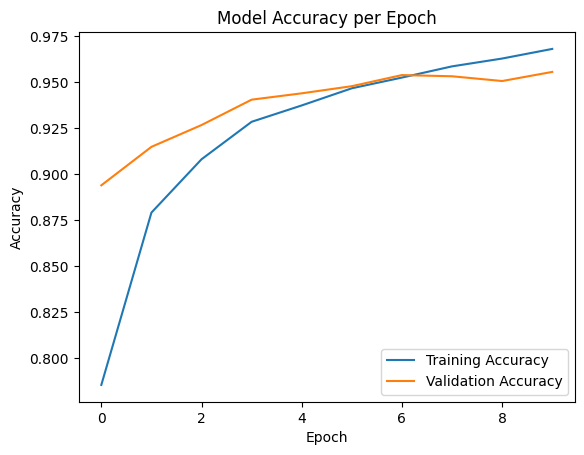

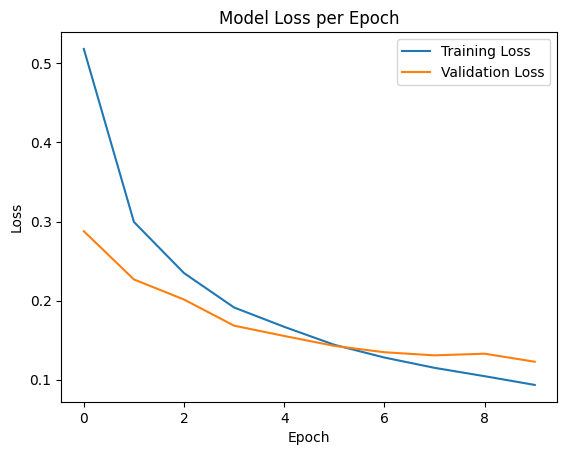

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Testing

In [ ]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I am so happy today"]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
['sad' 'happy']
